In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tabulate import tabulate

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LeakyReLU, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2025-03-14 12:44:54.969596: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-14 12:44:55.082022: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-14 12:44:55.112124: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-14 12:44:55.296313: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-14 12:44:57.152495: W tensorflow/compiler/tf2

In [2]:
### Neural Network implementation (Keras)

start_time_nn = time.time()
data = pd.read_csv('ind_output_2D.csv')

X = data.iloc[:, :11]           
X = X.drop('npz', axis=1)       
Y = data.iloc[:, -1]             

X_train_nn, X_test_nn, Y_train_log_nn, Y_test_log_nn = train_test_split(X, np.log(Y), test_size=0.2, random_state=36)

scaler = StandardScaler()
X_train_nn = scaler.fit_transform(X_train_nn)
X_test_nn = scaler.transform(X_test_nn)

# Define neural network architecture with LeakyReLU activations 

model = Sequential([
    Dense(64, input_dim=X_train_nn.shape[1]),
    LeakyReLU(alpha=0.01),
    Dense(32),
    LeakyReLU(alpha=0.01),
    Dense(1, activation='linear')
    ])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Set up callbacks for early stopping and learning rate reduction
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# Train the model
training = model.fit(X_train_nn, Y_train_log_nn, epochs=100, validation_split=0.2, batch_size=512,
                     verbose=2, callbacks=[early_stop, reduce_lr])

end_time_nn = time.time()

# Save the model
model.save('keras_nn_model.h5')
print("Model saved to 'keras_nn_model.h5'.")

# Predict the model
Y_pred_test_log_nn = model.predict(X_test_nn)
Y_pred_train_log_nn = model.predict(X_train_nn)

# Return the responses to the origina scale
Y_pred_test_nn = np.exp(Y_pred_test_log_nn)
Y_pred_train_nn = np.exp(Y_pred_train_log_nn)
Y_test_nn = np.exp(Y_test_log_nn)
Y_train_nn = np.exp(Y_train_log_nn)

Y_pred_test_nn = np.squeeze(Y_pred_test_nn)

running_time_nn = end_time_nn - start_time_nn

# Evaluate the model
def mean_relative_squared_error(Y_true, Y_pred_test):
    return np.mean(((Y_true - Y_pred_test)/Y_true)**2)

r2_nn = r2_score(Y_test_nn, Y_pred_test_nn)
mse_nn = mean_squared_error(Y_test_nn, Y_pred_test_nn)
mae_nn = mean_absolute_error(Y_test_nn, Y_pred_test_nn)
mslr_nn = mean_squared_log_error(Y_test_nn, Y_pred_test_nn)
mrse_nn = mean_relative_squared_error(Y_test_nn, Y_pred_test_nn)

eval_metrics_nn = {
    'Eval_metrics': ['R2 Score', 
                     'Mean Squared Error',
                     'Mean Absolute Error',  
                     'Mean Squared Log Error',
                     'Mean Relative Squeared Error', 
                     'Training time (s)'],
    'NN Keras': [r2_nn, 
                mse_nn, 
                mae_nn, 
                mslr_nn, 
                mrse_nn,
                running_time_nn]
}
df_metrics_nn = pd.DataFrame(eval_metrics_nn)
df_metrics_nn.to_csv('metrics_nn.csv', index=False)
print(df_metrics_nn)
print(tabulate(df_metrics_nn.round(4), headers='keys', tablefmt='pretty', showindex=False))

/home/chris/venv/cdd/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/chris/venv/cdd/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
1440/1440 - 3s - 2ms/step - loss: 0.0768 - mean_absolute_error: 0.1221 - val_loss: 0.0127 - val_mean_absolute_error: 0.0835 - learning_rate: 0.0010
Epoch 2/100
1440/1440 - 3s - 2ms/step - loss: 0.0123 - mean_absolute_error: 0.0824 - val_loss: 0.0119 - val_mean_absolute_error: 0.0807 - learning_rate: 0.0010
Epoch 3/100
1440/1440 - 3s - 2ms/step - loss: 0.0116 - mean_absolute_error: 0.0799 - val_loss: 0.0113 - val_mean_absolute_error: 0.0794 - learning_rate: 0.0010
Epoch 4/100
1440/1440 - 3s - 2ms/step - loss: 0.0110 - mean_absolute_error: 0.0774 - val_loss: 0.0105 - val_mean_absolute_error: 0.0756 - learning_rate: 0.0010
Epoch 5/100
1440/1440 - 3s - 2ms/step - loss: 0.0104 - mean_absolute_error: 0.0753 - val_loss: 0.0098 - val_mean_absolute_error: 0.0729 - learning_rate: 0.0010
Epoch 6/100
1440/1440 - 3s - 2ms/step - loss: 0.0098 - mean_absolute_error: 0.0729 - val_loss: 0.0094 - val_mean_absolute_error: 0.0706 - learning_rate: 0.0010
Epoch 7/100
1440/1440 - 3s - 2ms/step - 

Model saved to 'keras_nn_model.h5'.
7200/7200 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
28800/28800 ━━━━━━━━━━━━━━━━━━━━ 23s 801us/step
                   Eval_metrics    NN Keras
0                      R2 Score    0.997192
1            Mean Squared Error    0.480266
2           Mean Absolute Error    0.388768
3        Mean Squared Log Error    0.002325
4  Mean Relative Squeared Error    0.006956
5             Training time (s)  285.198961
+------------------------------+----------+
|         Eval_metrics         | NN Keras |
+------------------------------+----------+
|           R2 Score           |  0.9972  |
|      Mean Squared Error      |  0.4803  |
|     Mean Absolute Error      |  0.3888  |
|    Mean Squared Log Error    |  0.0023  |
| Mean Relative Squeared Error |  0.007   |
|      Training time (s)       | 285.199  |
+------------------------------+----------+


In [23]:
print(tabulate(df_metrics_nn.round(4), headers='keys', tablefmt='pretty', showindex=False))

+------------------------------+----------+
|         Eval_metrics         | NN Keras |
+------------------------------+----------+
|           R2 Score           |  0.9973  |
|      Mean Squared Error      |  0.4565  |
|     Mean Absolute Error      |  0.3805  |
|    Mean Squared Log Error    |  0.0023  |
| Mean Relative Squeared Error |  0.0069  |
|      Training time (s)       | 163.1696 |
+------------------------------+----------+


In [ ]:
# Load the model and test
from tensorflow.keras.models import load_model

loaded_model = load_model('keras_nn_model.h5')

# Test the loaded model
sample_prediction = loaded_model.predict(X_test_nn[:1]) 
print("Sample prediction from the loaded model:", np.exp(sample_prediction))

### (X_test_nn[:1]) to extract only the first sample (a single row) from the X_test_nn array. This approach is 
# commonly used for testing or demonstrating a single prediction without running inference on the 
# entire dataset.

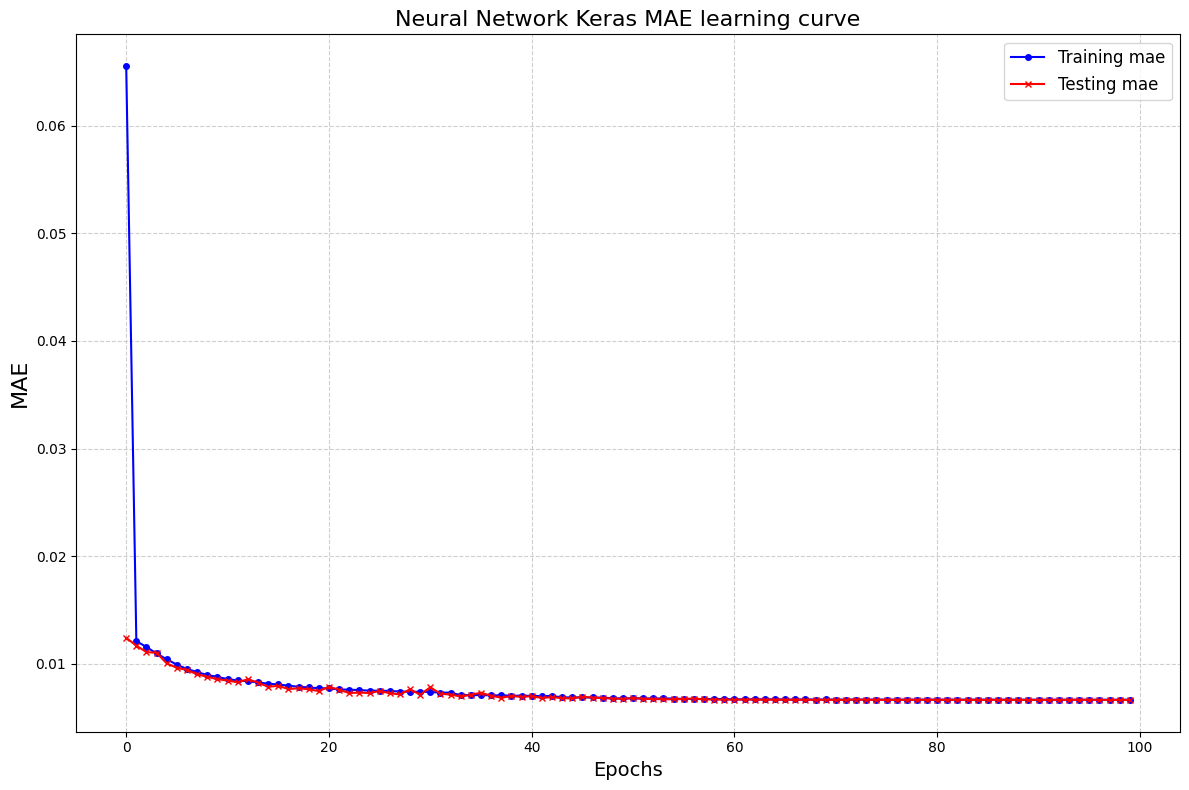

In [ ]:
### Neural Network plots
# Learning Curve Plot
plt.figure(figsize=(12, 8))
plt.plot(training.history['loss'], label='Training mae', color='b', marker='o', markersize=4)
plt.plot(training.history['val_loss'], label='Testing mae', color='r', marker='x', markersize=4)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('MAE', fontsize=16)
plt.title('Neural Network Keras MAE learning curve', fontsize=16)
plt.grid(visible=True, which='both', linestyle='--', alpha=0.6)
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.show()

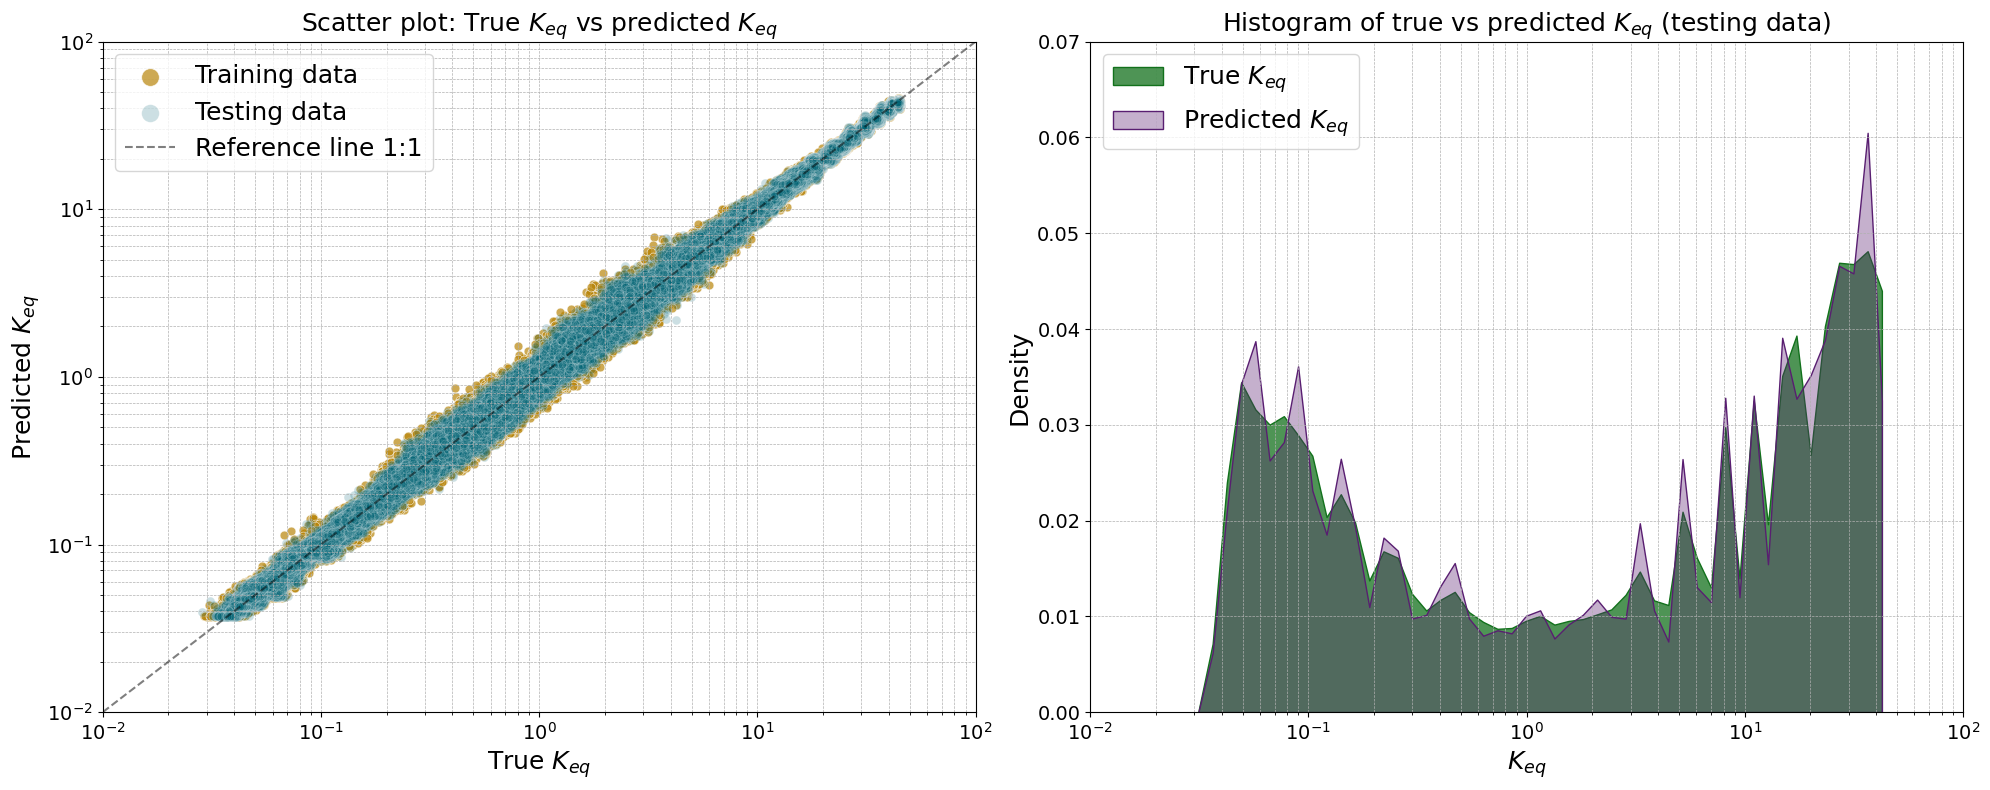

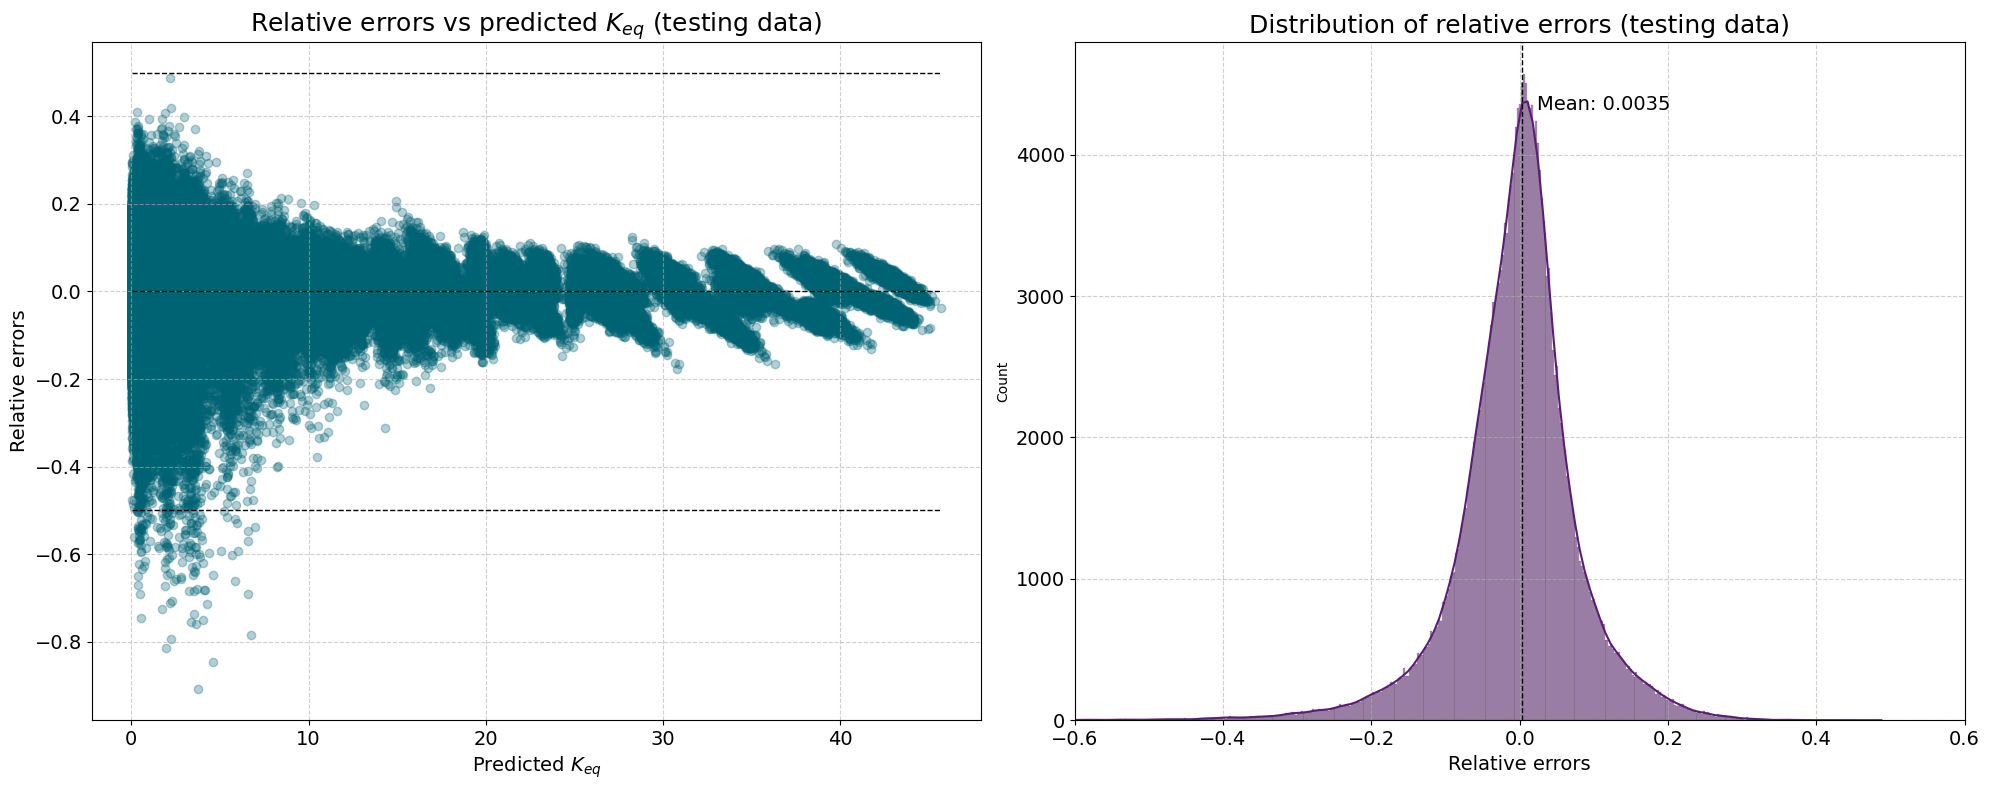

In [ ]:
### Keras NN plots
# Filter data
data_plot_train_nn = pd.DataFrame(Y_train_nn)
data_plot_train_nn['Y_pred_train_nn'] = Y_pred_train_nn
data_plot_train_rel_nn = ((data_plot_train_nn['keff']-data_plot_train_nn['Y_pred_train_nn'])/data_plot_train_nn['keff'])

data_plot_test_nn = pd.DataFrame(Y_test_nn)
data_plot_test_nn['Y_pred_test_nn'] = Y_pred_test_nn
data_plot_test_rel_nn = ((data_plot_test_nn['keff']-data_plot_test_nn['Y_pred_test_nn'])/data_plot_test_nn['keff'])

# Scatter plot for training data
palette = sns.color_palette('dark')
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
sns.scatterplot(
    x='keff', 
    y='Y_pred_train_nn', 
    data=data_plot_train_nn,
    label='Training data', 
    color=palette[8], 
    s=40,  
    alpha=0.70)
sns.scatterplot(
    x='keff', 
    y='Y_pred_test_nn', 
    data=data_plot_test_nn,
    label='Testing data', 
    color=palette[9], 
    s=40,  
    alpha=0.20)

plt.loglog([1E-2, 1E2], [1E-2, 1E2], c='k', alpha=0.50, linestyle='--', label='Reference line 1:1')
plt.legend(loc='upper left', fontsize=18, markerscale=2)
plt.xlim([1E-2, 1E2])
plt.ylim([1E-2, 1E2])
plt.xlabel('True '+r'$K_{eq}$', fontsize=18)
plt.ylabel('Predicted '+r'$K_{eq}$', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.title('Scatter plot: True '+r'$K_{eq}$'+' vs predicted '+r'$K_{eq}$', fontsize=18)

# Histogram for testing data
plt.subplot(1, 2, 2)
logMin, logMax = np.log10(data_plot_train_nn['keff'].min()), np.log10(data_plot_train_nn['keff'].max())
newBins = np.logspace(logMin, logMax, 50)
sns.histplot(
    data_plot_test_nn['keff'], 
    bins=newBins, 
    kde=False, 
    color=palette[2],
    stat="probability", 
    element='poly', 
    label='True '+r'$K_{eq}$', 
    alpha=0.75)
sns.histplot(
    data_plot_test_nn['Y_pred_test_nn'], 
    bins=newBins, 
    kde=False, 
    color=palette[4], 
    stat="probability", 
    element='poly', 
    label='Predicted '+r'$K_{eq}$', 
    alpha=0.35)

plt.legend(loc='upper left', fontsize=18)
plt.xlim([1E-2, 1E2])
plt.ylim([0, 0.07])
plt.xscale('log')
plt.ylabel("Density", fontsize=18)
plt.xlabel(r'$K_{eq}$', fontsize=18)
plt.title('Histogram of true vs predicted '+r'$K_{eq}$'+' (testing data)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

# Relative error plot
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
relative_nn = (Y_test_nn - Y_pred_test_nn) / Y_test_nn
plt.scatter(Y_pred_test_nn, relative_nn, alpha=0.3, color=palette[9])
plt.hlines(y=0, xmin=Y_pred_test_nn.min(), xmax=Y_pred_test_nn.max(), colors='k', linestyles='--', linewidth=1)
plt.hlines(y=0.5, xmin=Y_pred_test_nn.min(), xmax=Y_pred_test_nn.max(), colors='k', linestyles='--', linewidth=1)
plt.hlines(y=-0.5, xmin=Y_pred_test_nn.min(), xmax=Y_pred_test_nn.max(), colors='k', linestyles='--', linewidth=1)
plt.xlabel('Predicted '+r'$K_{eq}$', fontsize=14)
plt.ylabel('Relative errors', fontsize=14)
plt.title('Relative errors vs predicted '+r'$K_{eq}$'+' (testing data)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True, linestyle='--', alpha=0.6)

# Error distribution plot
plt.subplot(1, 2, 2)
sns.histplot(relative_nn, kde=True, color=palette[4], alpha=0.5)
plt.xlabel('Relative errors', fontsize=14)
plt.xlim(-0.6, 0.6)
plt.title('Distribution of relative errors (testing data)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
mean_residual_nn = abs(relative_nn.mean())
plt.axvline(mean_residual_nn, color='k', linestyle='--', linewidth=1)
plt.text(mean_residual_nn + 0.02, plt.ylim()[1] * 0.9, f'Mean: {mean_residual_nn:.4f}', color='k', fontsize=14)
plt.tight_layout()
plt.show()

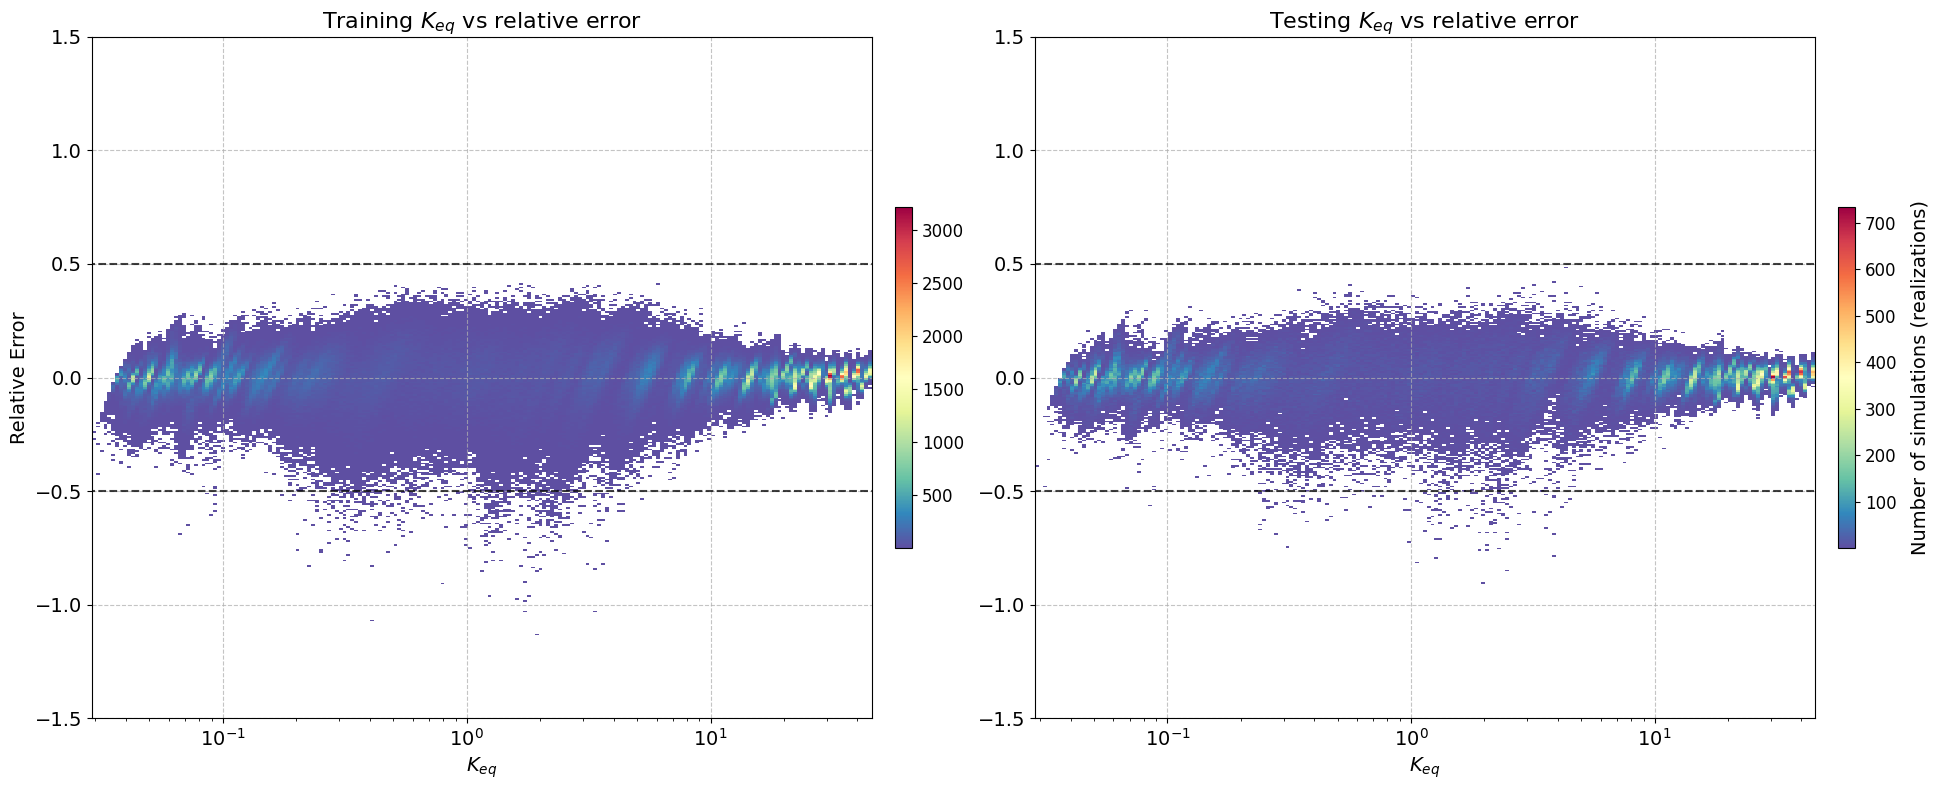

In [5]:
# 2D Histogram Keff relative error for training data
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
x = data_plot_train_nn['keff']
y = data_plot_train_rel_nn
LogMin, LogMax = np.log10(data_plot_train_nn['keff'].min()), np.log10(data_plot_train_nn['keff'].max())
newBins = np.logspace(LogMin, LogMax, 200)
hist2d = plt.hist2d(x, y, bins=[newBins, 200], cmap=plt.cm.Spectral_r, cmin=1)
cbar = plt.colorbar(pad=0.025, shrink=0.5)#.ax.set_yscale('log')
#cbar.set_label(label='Number of simulations (realizations)', fontsize=14, labelpad=10)
cbar.ax.tick_params(labelsize=12)
plt.plot([1E-3, 1E2], [0.5, 0.5], c='k', alpha=0.75, linestyle='--')
plt.plot([1E-3, 1E2], [-0.5, -0.5], c='k', alpha=0.75, linestyle='--')
plt.xscale('log')
plt.xlabel(r'$K_{eq}$',  fontsize=14)
plt.ylim([-1.5, 1.5])
plt.ylabel('Relative Error', fontsize=14)
plt.title('Training '+r'$K_{eq}$'+' vs relative error', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True, linestyle='--', alpha=0.75)
plt.tight_layout()

# 2D Histograms Keff relative error for testing data
plt.subplot(1, 2, 2)
x = data_plot_test_nn['keff']
y = data_plot_test_rel_nn
LogMin, LogMax = np.log10(data_plot_test_nn['keff'].min()), np.log10(data_plot_test_nn['keff'].max())
newBins = np.logspace(LogMin, LogMax, 200)
hist2d = plt.hist2d(x, y, bins=[newBins, 200], cmap=plt.cm.Spectral_r, cmin=1)
cbar = plt.colorbar(pad=0.025, shrink=0.5)#.ax.set_yscale('log')
cbar.set_label(label='Number of simulations (realizations)', fontsize=14, labelpad=10)
cbar.ax.tick_params(labelsize=12)
plt.plot([1E-3, 1E2], [0.5, 0.5], c='k', alpha=0.75, linestyle='--')
plt.plot([1E-3, 1E2], [-0.5, -0.5], c='k', alpha=0.75, linestyle='--')
plt.xscale('log')
plt.xlabel(r'$K_{eq}$',  fontsize=14)
plt.ylim([-1.5, 1.5])
#plt.ylabel('Relative Error', fontsize=14)
plt.title('Testing '+r'$K_{eq}$'+' vs relative error', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True, linestyle='--', alpha=0.75)
plt.tight_layout()
plt.show()

In [9]:
error_data1 = data_plot_train_rel_nn[data_plot_train_rel_nn <= -0.5]
error_data2 = data_plot_train_rel_nn[data_plot_train_rel_nn >= 0.5]
error_training = ((len(error_data1)+len(error_data2))/len(data_plot_train_rel_nn))*100
print('El error en las predicciones de los datos de entrenamiento: ', f'{error_training:.2f}','%')

error_data3 = data_plot_test_rel_nn[data_plot_test_rel_nn <= -0.5]
error_data4 = data_plot_test_rel_nn[data_plot_test_rel_nn >= 0.5]
error_testing = ((len(error_data3)+len(error_data4))/len(data_plot_test_rel_nn))*100
print('El error en las predicciones de los datos de validaición: ', f'{error_testing:.2f}','%')

print(len(error_data1)+len(error_data2))
print(len(error_data3)+len(error_data4))
print(len(data_plot_train_rel_nn))
print(len(data_plot_test_rel_nn))

El error en las predicciones de los datos de entrenamiento:  0.07 %
El error en las predicciones de los datos de validaición:  0.07 %
616
164
921600
230400


In [10]:
### Simple Decision Tree method

from sklearn.tree import DecisionTreeRegressor
import joblib

start_time_dt = time.time()
X_train_dt, X_test_dt, Y_train_dt, Y_test_dt = train_test_split(X, Y, test_size=.2, random_state=36)

# Parameters tuning
tree_regressor = DecisionTreeRegressor()
param_grid_dt = {'criterion': ['squared_error'],
            'max_depth': [2, 5, 10],
            'min_samples_split': [2, 5, 10],
            'max_leaf_nodes': [2, 10, 50],
            'min_impurity_decrease': [0, 0.01, 0.1]}

grid_search_dt = GridSearchCV(estimator=tree_regressor, param_grid=param_grid_dt, cv=5, verbose=3, scoring='neg_mean_squared_error')
grid_search_dt.fit(X_train_dt, Y_train_dt)
best_model_dt = grid_search_dt.best_estimator_
print(f'Decision tree regressor best parameters: {best_model_dt}')
best_model_dt.fit(X_train_dt, Y_train_dt)     

Y_pred_test_dt = best_model_dt.predict(X_test_dt)
Y_pred_train_dt = best_model_dt.predict(X_train_dt)

end_time_dt = time.time()
running_time_dt = end_time_dt - start_time_dt

r2_dt= r2_score(Y_test_dt, Y_pred_test_dt)
mse_dt = mean_squared_error(Y_test_dt, Y_pred_test_dt)
mslr_dt = mean_squared_log_error(Y_test_dt, Y_pred_test_dt)
mae_dt = mean_absolute_error(Y_test_dt, Y_pred_test_dt)
mrse_dt = mean_relative_squared_error(Y_test_dt, Y_pred_test_dt)

eval_metrics_dt = {
    'Eval_metrics': ['R2 Score', 
                     'Mean squared error',
                     'Mean absolute error', 
                     'Mean squared log error', 
                     'Mean relative squared error',
                     'Training time (s)'],
    'Decision Tree': [r2_dt, 
                      mse_dt, 
                      mae_dt, 
                      mslr_dt, 
                      mrse_dt,
                      running_time_dt]
}
df_metrics_dt = pd.DataFrame(eval_metrics_dt)
df_metrics_dt.to_csv('metrics_dt.csv', index=False)
print(df_metrics_dt)

joblib.dump(tree_regressor, 'dt_model.joblib')
print("Decision Tree model saved as 'decision_tree_model.joblib'.")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV 1/5] END criterion=squared_error, max_depth=2, max_leaf_nodes=2, min_impurity_decrease=0, min_samples_split=2;, score=-35.763 total time=   1.5s
[CV 2/5] END criterion=squared_error, max_depth=2, max_leaf_nodes=2, min_impurity_decrease=0, min_samples_split=2;, score=-36.119 total time=   1.4s
[CV 3/5] END criterion=squared_error, max_depth=2, max_leaf_nodes=2, min_impurity_decrease=0, min_samples_split=2;, score=-36.165 total time=   1.4s
[CV 4/5] END criterion=squared_error, max_depth=2, max_leaf_nodes=2, min_impurity_decrease=0, min_samples_split=2;, score=-36.102 total time=   1.4s
[CV 5/5] END criterion=squared_error, max_depth=2, max_leaf_nodes=2, min_impurity_decrease=0, min_samples_split=2;, score=-36.212 total time=   1.5s
[CV 1/5] END criterion=squared_error, max_depth=2, max_leaf_nodes=2, min_impurity_decrease=0, min_samples_split=5;, score=-35.763 total time=   1.4s
[CV 2/5] END criterion=squared_error, max_de

/home/chris/venv/cdd/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Decision tree regressor best parameters: DecisionTreeRegressor(max_depth=10, max_leaf_nodes=50, min_impurity_decrease=0,
                      min_samples_split=10)
                  Eval_metrics  Decision Tree
0                     R2 Score       0.996673
1           Mean squared error       0.569025
2          Mean absolute error       0.470597
3       Mean squared log error       0.012698
4  Mean relative squared error       0.827286
5            Training time (s)     979.399745
Decision Tree model saved as 'decision_tree_model.joblib'.


In [15]:
dt = pd.read_csv('metrics_dt.csv')
print(tabulate(dt.round(5), headers='keys', tablefmt='pretty', showindex=False))

+-----------------------------+---------------+
|        Eval_metrics         | Decision Tree |
+-----------------------------+---------------+
|          R2 Score           |    0.99667    |
|     Mean squared error      |    0.56902    |
|     Mean absolute error     |    0.4706     |
|   Mean squared log error    |    0.0127     |
| Mean relative squared error |    0.82729    |
|      Training time (s)      |   979.39974   |
+-----------------------------+---------------+


In [ ]:
# Load the model
loaded_dt_model = joblib.load('dt_model.joblib')
sample_prediction_dt = loaded_dt_model.predict(X_test_dt[:5])
print("Sample predictions from the loaded decision tree (joblib):", sample_prediction)

In [ ]:
### Generalized Linear Model - Tweedie Regressor
from sklearn.linear_model import TweedieRegressor
import joblib

# Instatiate the regressor

start_time_tr = time.time()
X_train_tr, X_test_tr, Y_train_tr, Y_test_tr = train_test_split(X, Y, test_size=.2, random_state=36)

'''tw_regressor = TweedieRegressor(power=1, alpha=0.05, max_iter=300, tol=1e-4)    # power = 1: for gaussian distribution.
tw_regressor.fit(X_train_tr, Y_train_tr)
Y_pred_test_tr = tw_regressor.predict(X_test_tr)
Y_pred_train_tr = tw_regressor.predict(X_train_tr)'''

### Parameters tuning
tw_regressor = TweedieRegressor()
param_grid_tw = {'power': [1, 1.5, 2], 'alpha': [0.1, 0.5, 0.9]}
grid_search_tw = GridSearchCV(estimator=tw_regressor, param_grid=param_grid_tw, scoring='neg_mean_squared_error', cv=5, verbose=3)

grid_search_tw.fit(X_train_tr, Y_train_tr)
best_model_tw = grid_search_tw.best_estimator_
print(f'Tweedie regressor best parameters: {best_model_tw}')

best_model_tw.fit(X_train_tr, Y_train_tr)

Y_pred_test_tr = best_model_tw.predict(X_test_tr)
Y_pred_train_tr = best_model_tw.predict(X_train_tr)


r2_tr= r2_score(Y_test_tr, Y_pred_test_tr)
mse_tr = mean_squared_error(Y_test_tr, Y_pred_test_tr)
mslr_tr = mean_squared_log_error(Y_test_tr, Y_pred_test_tr)
mae_tr = mean_absolute_error(Y_test_tr, Y_pred_test_tr)
mrse_tr = mean_relative_squared_error(Y_test_tr, Y_pred_test_tr)

end_time_tr = time.time()
running_time_tr = end_time_tr - start_time_tr

eval_metrics_tr = {
    'Eval_metrics': ['R2 Score', 
                     'Mean squared error',
                     'Mean absolute error', 
                     'Mean squared log error', 
                     'Mean relative squared error',
                     'Training time (s)'],
    'GLM TW': [r2_tr, 
               mse_tr, 
               mae_tr, 
               mslr_tr, 
               mrse_tr,
               running_time_tr]
}
df_metrics_tr = pd.DataFrame(eval_metrics_tr)
df_metrics_tr.to_csv('metrics_tr.csv', index=False)
print(df_metrics_tr)

# Save the model
joblib.dump(tw_regressor, 'tweedie_regressor.joblib')
print("Tweedie Regressor model saved as 'tweedie_regressor.joblib'.")


print(tabulate(df_metrics_tr.round(4), headers='keys', tablefmt='pretty', showindex=False))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/home/chris/venv/cdd/lib/python3.12/site-packages/sklearn/linear_model/_glm/glm.py:283: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 1/5] END ...............alpha=0.1, power=1;, score=-4.138 total time=   2.5s


/home/chris/venv/cdd/lib/python3.12/site-packages/sklearn/linear_model/_glm/glm.py:283: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 2/5] END ...............alpha=0.1, power=1;, score=-4.132 total time=   2.7s


/home/chris/venv/cdd/lib/python3.12/site-packages/sklearn/linear_model/_glm/glm.py:283: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 3/5] END ...............alpha=0.1, power=1;, score=-4.106 total time=   2.8s


/home/chris/venv/cdd/lib/python3.12/site-packages/sklearn/linear_model/_glm/glm.py:283: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 4/5] END ...............alpha=0.1, power=1;, score=-5.356 total time=   2.5s


/home/chris/venv/cdd/lib/python3.12/site-packages/sklearn/linear_model/_glm/glm.py:283: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 5/5] END ...............alpha=0.1, power=1;, score=-4.099 total time=   2.7s
[CV 1/5] END ...........alpha=0.1, power=1.5;, score=-171.328 total time=   0.2s
[CV 2/5] END ...........alpha=0.1, power=1.5;, score=-171.097 total time=   0.2s
[CV 3/5] END ...........alpha=0.1, power=1.5;, score=-171.379 total time=   0.2s
[CV 4/5] END ...........alpha=0.1, power=1.5;, score=-170.686 total time=   0.2s
[CV 5/5] END ...........alpha=0.1, power=1.5;, score=-171.249 total time=   0.2s
[CV 1/5] END .............alpha=0.1, power=2;, score=-171.328 total time=   0.1s
[CV 2/5] END .............alpha=0.1, power=2;, score=-171.097 total time=   0.1s
[CV 3/5] END .............alpha=0.1, power=2;, score=-171.379 total time=   0.1s
[CV 4/5] END .............alpha=0.1, power=2;, score=-170.686 total time=   0.1s
[CV 5/5] END .............alpha=0.1, power=2;, score=-171.249 total time=   0.1s


/home/chris/venv/cdd/lib/python3.12/site-packages/sklearn/linear_model/_glm/glm.py:283: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 1/5] END ...............alpha=0.5, power=1;, score=-5.563 total time=   2.9s


/home/chris/venv/cdd/lib/python3.12/site-packages/sklearn/linear_model/_glm/glm.py:283: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 2/5] END ...............alpha=0.5, power=1;, score=-5.562 total time=   2.9s


/home/chris/venv/cdd/lib/python3.12/site-packages/sklearn/linear_model/_glm/glm.py:283: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 3/5] END ...............alpha=0.5, power=1;, score=-5.032 total time=   3.1s


/home/chris/venv/cdd/lib/python3.12/site-packages/sklearn/linear_model/_glm/glm.py:283: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 4/5] END ...............alpha=0.5, power=1;, score=-5.336 total time=   3.0s


/home/chris/venv/cdd/lib/python3.12/site-packages/sklearn/linear_model/_glm/glm.py:283: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 5/5] END ...............alpha=0.5, power=1;, score=-5.445 total time=   3.1s
[CV 1/5] END ...........alpha=0.5, power=1.5;, score=-171.328 total time=   0.2s
[CV 2/5] END ...........alpha=0.5, power=1.5;, score=-171.097 total time=   0.2s
[CV 3/5] END ...........alpha=0.5, power=1.5;, score=-171.379 total time=   0.2s
[CV 4/5] END ...........alpha=0.5, power=1.5;, score=-170.686 total time=   0.2s
[CV 5/5] END ...........alpha=0.5, power=1.5;, score=-171.249 total time=   0.3s
[CV 1/5] END .............alpha=0.5, power=2;, score=-171.328 total time=   0.2s
[CV 2/5] END .............alpha=0.5, power=2;, score=-171.097 total time=   0.2s
[CV 3/5] END .............alpha=0.5, power=2;, score=-171.379 total time=   0.2s
[CV 4/5] END .............alpha=0.5, power=2;, score=-170.686 total time=   0.1s
[CV 5/5] END .............alpha=0.5, power=2;, score=-171.249 total time=   0.1s


/home/chris/venv/cdd/lib/python3.12/site-packages/sklearn/linear_model/_glm/glm.py:283: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 1/5] END ...............alpha=0.9, power=1;, score=-5.267 total time=   3.0s


/home/chris/venv/cdd/lib/python3.12/site-packages/sklearn/linear_model/_glm/glm.py:283: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 2/5] END ...............alpha=0.9, power=1;, score=-5.011 total time=   2.7s


/home/chris/venv/cdd/lib/python3.12/site-packages/sklearn/linear_model/_glm/glm.py:283: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 3/5] END ...............alpha=0.9, power=1;, score=-5.066 total time=   2.7s


/home/chris/venv/cdd/lib/python3.12/site-packages/sklearn/linear_model/_glm/glm.py:283: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 4/5] END ...............alpha=0.9, power=1;, score=-5.873 total time=   2.9s


/home/chris/venv/cdd/lib/python3.12/site-packages/sklearn/linear_model/_glm/glm.py:283: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 5/5] END ...............alpha=0.9, power=1;, score=-5.752 total time=   3.0s
[CV 1/5] END ...........alpha=0.9, power=1.5;, score=-171.328 total time=   0.2s
[CV 2/5] END ...........alpha=0.9, power=1.5;, score=-171.097 total time=   0.2s
[CV 3/5] END ...........alpha=0.9, power=1.5;, score=-171.379 total time=   0.2s
[CV 4/5] END ...........alpha=0.9, power=1.5;, score=-170.686 total time=   0.2s
[CV 5/5] END ...........alpha=0.9, power=1.5;, score=-171.249 total time=   0.2s
[CV 1/5] END .............alpha=0.9, power=2;, score=-171.328 total time=   0.1s
[CV 2/5] END .............alpha=0.9, power=2;, score=-171.097 total time=   0.1s
[CV 3/5] END .............alpha=0.9, power=2;, score=-171.379 total time=   0.1s
[CV 4/5] END .............alpha=0.9, power=2;, score=-170.686 total time=   0.1s
[CV 5/5] END .............alpha=0.9, power=2;, score=-171.249 total time=   0.1s


/home/chris/venv/cdd/lib/python3.12/site-packages/sklearn/linear_model/_glm/glm.py:283: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Tweedie regressor best parameters: TweedieRegressor(alpha=0.1, power=1)
                  Eval_metrics     GLM TW
0                     R2 Score   0.969644
1           Mean squared error   5.191655
2          Mean absolute error   1.460015
3       Mean squared log error   0.046623
4  Mean relative squared error   0.512199
5            Training time (s)  54.971545
Tweedie Regressor model saved as 'tweedie_regressor.joblib'.
+-----------------------------+----------+
|        Eval_metrics         |  GLM TW  |
+-----------------------------+----------+
|          R2 Score           | 0.96964  |
|     Mean squared error      | 5.19166  |
|     Mean absolute error     | 1.46001  |
|   Mean squared log error    | 0.04662  |
| Mean relative squared error |  0.5122  |
|      Training time (s)      | 54.97154 |
+-----------------------------+----------+


/home/chris/venv/cdd/lib/python3.12/site-packages/sklearn/linear_model/_glm/glm.py:283: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


In [ ]:
# Load the model
loaded_tw_model = joblib.load('tweedie_regressor.joblib')
sample_prediction = loaded_tw_model.predict(X_test_tr[:5])
print("Sample predictions from the loaded Tweedie Regressor (joblib):", sample_prediction)

In [20]:
### Linear Model - Elastic Net
from sklearn.linear_model import ElasticNet
# Elastic Net is a regularization technique that combines Lasso (L1) and Ridge (L2) penalties.

start_time_lm = time.time()

X_train_lm, X_test_lm, Y_train_log_lm, Y_test_log_lm = train_test_split(X, np.log(Y), test_size=.2, random_state=36)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_lm)
X_test = scaler.transform(X_test_lm)

elastic_net = ElasticNet()
param_lm = {'alpha': [0.1, 1, 10],
            'l1_ratio': [0.1, 0.5, 0.9]}

param_grid_lm = GridSearchCV(estimator = elastic_net, param_grid = param_lm, verbose=3,
                        cv = 5, scoring = 'neg_mean_squared_error')

# Setting up grid search
# estimator: model to be optimized: elastic_net
# param_grid: dictionary of parameters to be tested
# cv: number of split for cross-validation (5- fold cross-validation: validación cruzada quintuple)
# scoring: evaluation metric, mean squared error is used here, GridSearchCV maximizes this metric

# Perform grid search
# fit: fit the model to the training data: X_train. Y_train_log
param_grid_lm.fit(X_train_lm, Y_train_log_lm)

# Get the best model
# best_estimator_: Gets the best mdeol found by GridSearchCV
# predict: Uses the best model to make prediction on the test dat X_test
best_model_lm = param_grid_lm.best_estimator_
print(f'Best hyperparameters: {best_model_lm}')

Y_pred_test_log_lm = best_model_lm.predict(X_test_lm)
Y_pred_train_log_lm = best_model_lm.predict(X_train_lm)

Y_pred_test_lm = np.exp(Y_pred_test_log_lm)
Y_pred_train_lm = np.exp(Y_pred_train_log_lm)
Y_test_lm = np.exp(Y_test_log_lm)
Y_train_lm = np.exp(Y_train_log_lm)

end_time_lm = time.time()
running_time_lm = end_time_lm - start_time_lm

r2_lm= r2_score(Y_test_lm, Y_pred_test_lm)
mse_lm = mean_squared_error(Y_test_lm, Y_pred_test_lm)
mslr_lm = mean_squared_log_error(Y_test_lm, Y_pred_test_lm)
mae_lm = mean_absolute_error(Y_test_lm, Y_pred_test_lm)
mrse_lm = mean_relative_squared_error(Y_test_lm, Y_pred_test_lm)

eval_metrics_lm = {
    'Eval_metrics': ['R2 Score', 
                     'Mean squared error',
                     'Mean absolute error', 
                     'Mean squared log error', 
                     'Mean relative squared error',
                     'Training time (s)'],
    'LM EN': [r2_lm, 
               mse_lm, 
               mae_lm, 
               mslr_lm, 
               mrse_lm,
               running_time_lm]
}
df_metrics_lm = pd.DataFrame(eval_metrics_lm)
df_metrics_lm.to_csv('metrics_lm', index=False)
print(df_metrics_lm)

# Save the model
joblib.dump(best_model_lm, 'lineal_model.joblib')
print("Lineal model saved as 'lineal_model.joblib'.")

print(tabulate(df_metrics_lm.round(4), headers='keys', tablefmt='pretty', showindex=False))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ..........alpha=0.1, l1_ratio=0.1;, score=-0.214 total time=   1.7s
[CV 2/5] END ..........alpha=0.1, l1_ratio=0.1;, score=-0.212 total time=   1.2s
[CV 3/5] END ..........alpha=0.1, l1_ratio=0.1;, score=-0.214 total time=   2.0s
[CV 4/5] END ..........alpha=0.1, l1_ratio=0.1;, score=-0.213 total time=   1.0s
[CV 5/5] END ..........alpha=0.1, l1_ratio=0.1;, score=-0.213 total time=   1.4s
[CV 1/5] END ..........alpha=0.1, l1_ratio=0.5;, score=-0.226 total time=   0.8s
[CV 2/5] END ..........alpha=0.1, l1_ratio=0.5;, score=-0.225 total time=   0.7s
[CV 3/5] END ..........alpha=0.1, l1_ratio=0.5;, score=-0.227 total time=   0.6s
[CV 4/5] END ..........alpha=0.1, l1_ratio=0.5;, score=-0.225 total time=   0.7s
[CV 5/5] END ..........alpha=0.1, l1_ratio=0.5;, score=-0.226 total time=   0.8s
[CV 1/5] END ..........alpha=0.1, l1_ratio=0.9;, score=-0.227 total time=   0.6s
[CV 2/5] END ..........alpha=0.1, l1_ratio=0.9;, 

In [ ]:
# Load the model
loaded_lm_model = joblib.load('tlineal_model.joblib')
sample_prediction = loaded_lm_model.predict(X_test_lm[:5])
print("Sample predictions from the loaded Lineal Model (joblib):", sample_prediction)

In [21]:
import pandas as pd
from tabulate import tabulate

metrics = pd.read_csv('metrics_xgb.csv')
nn = pd.read_csv('metrics_nn.csv')
nn_GPU = pd.read_csv('metrics_nn_GPU.csv')
tr = pd.read_csv('metrics_tr.csv')
dt = pd.read_csv('metrics_dt.csv')
lm = pd.read_csv('metrics_lm.csv')

metrics['NN Keras'] = nn['NN Keras'].values
metrics['NN Keras GPU'] = nn_GPU['NN Keras'].values
metrics['Decision Tree'] = dt['Decision Tree'].values
metrics['GLM TW'] = tr['GLM TW'].values
metrics['LM EN'] = lm['LM EN'].values

metrics.to_csv('ind_eval_metrics.csv', index=False)

metrics.to_csv('metrics_xgb.csv', index=False)

print(tabulate(metrics, headers='keys', tablefmt='pretty', showindex=False))


+-----------------------------+------------+----------------+------------+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|        Eval_metrics         | XGBoost CV | XGBoost CV GPU | XGBoost RS | XGBoost RS GPU |      NN Keras      |    NN Keras GPU    |   Decision Tree    |       GLM TW       |       LM EN        |
+-----------------------------+------------+----------------+------------+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|          R2 Score           |  0.99802   |    0.99802     |  0.99806   |    0.99807     | 0.9973310790430036 | 0.9971602707470926 | 0.9966728818797598 | 0.9696441228632288 | 0.9206220993572504 |
|     Mean squared error      |  0.33963   |    0.34061     |  0.33246   |    0.33164     | 0.4564558351273771 | 0.485668556153204  | 0.5690248998047355 | 5.191655156802551  | 13.575713373437504 |
|     Mean abso

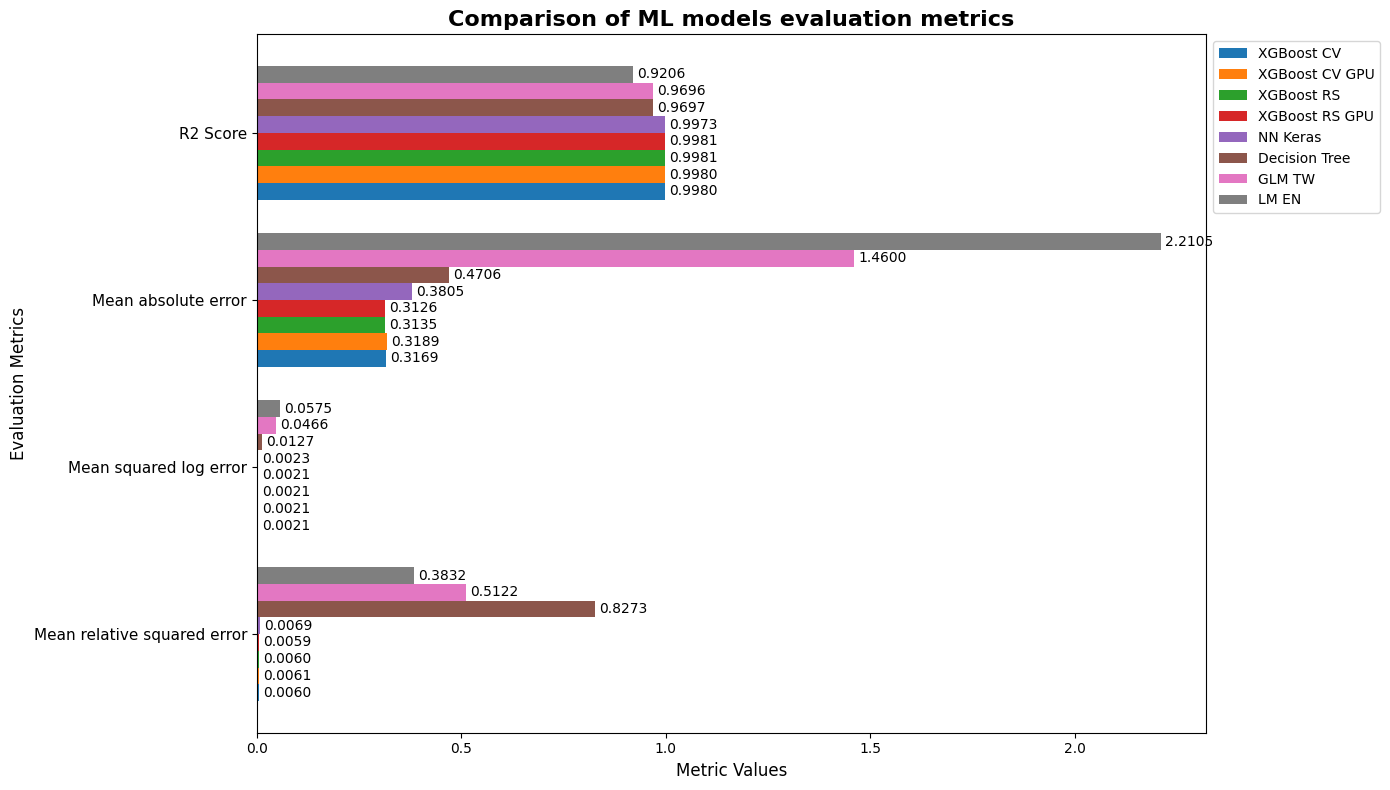

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = {
    'Eval_metrics': ['R2 Score', 'Mean absolute error', 'Mean squared log error', 'Mean relative squared error'],
    'XGBoost CV': [0.99802, 0.31691, 0.00208, 0.00601],
    'XGBoost CV GPU': [0.99802, 0.31891, 0.00212, 0.0061],
    'XGBoost RS': [0.99806, 0.3135, 0.00206, 0.00595],
    'XGBoost RS GPU': [0.99807, 0.31265, 0.00206, 0.00594],
    'NN Keras': [0.9973, 0.3805, 0.00223, 0.0069],
    'Decision Tree': [0.96967, 0.4706, 0.0127, 0.8273],
    'GLM TW': [0.9696, 1.46, 0.0466, 0.5122],
    'LM EN': [0.9206, 2.2105, 0.0575, 0.3832]
}

df = pd.DataFrame(data)

categories = df['Eval_metrics'][::-1]
models = df.columns[1:]
values = df.iloc[:, 1:].values[::-1]

y = np.arange(len(categories)) 
height = 0.1                   
fig, ax = plt.subplots(figsize=(14, 8))

for i, model in enumerate(models):
    bars = ax.barh(y + i * height, values[:, i], height, label=model)
    for bar, value in zip(bars, values[:, i]):
        ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
                f'{value:.4f}', va='center', ha='left', fontsize=10)

ax.set_ylabel('Evaluation Metrics', fontsize=12)
ax.set_xlabel('Metric Values', fontsize=12)
ax.set_title('Comparison of ML models evaluation metrics', fontsize=16, weight='bold')
ax.set_yticks(y + height * (len(models) - 1) / 2)
ax.set_yticklabels(categories, fontsize=11)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
plt.tight_layout()
plt.show()


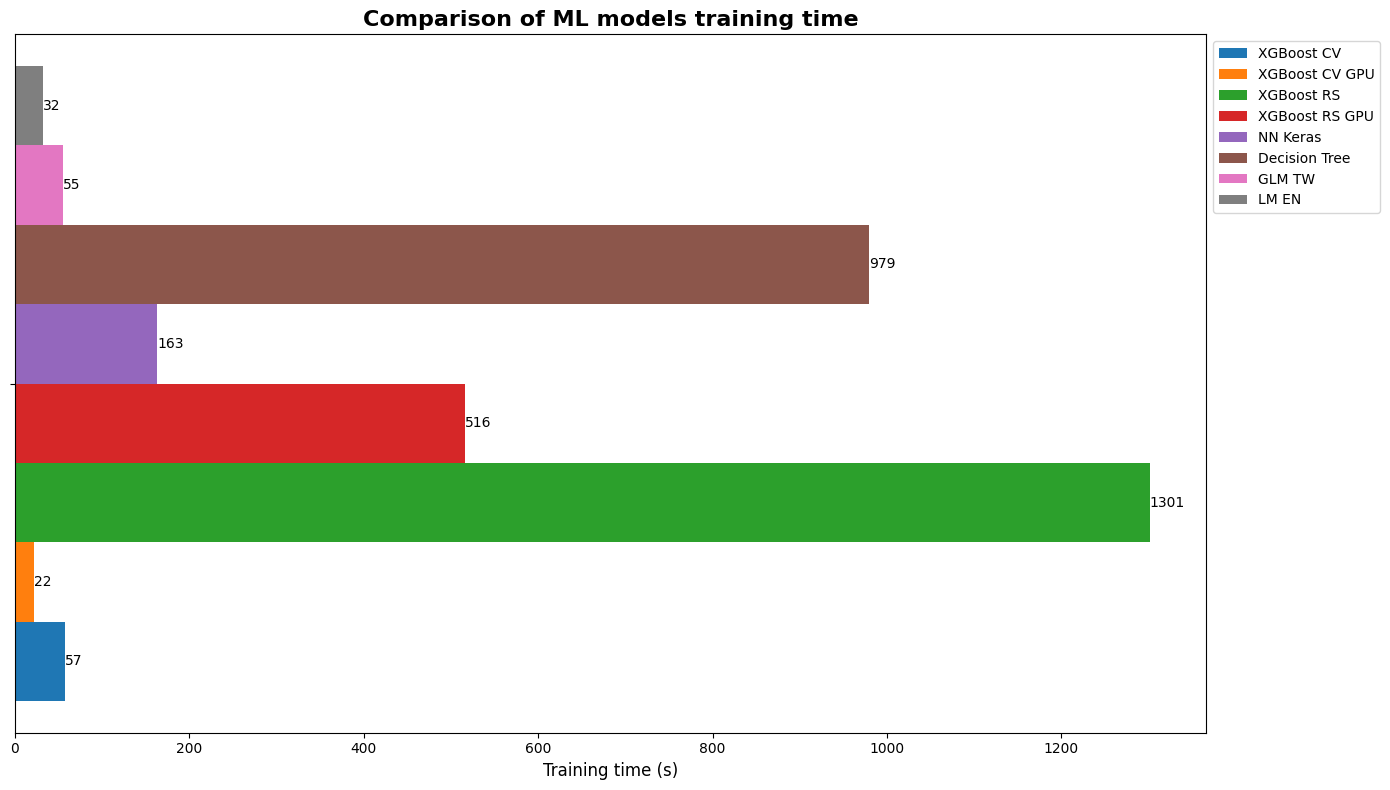

In [24]:

data = {
    'Eval_metrics': [''],
    'XGBoost CV': [57],
    'XGBoost CV GPU': [22],
    'XGBoost RS': [1301],
    'XGBoost RS GPU': [516],
    'NN Keras': [163],
    'Decision Tree': [979],
    'GLM TW': [55],
    'LM EN': [32]
}

df = pd.DataFrame(data)

categories = df['Eval_metrics'][::-1]
models = df.columns[1:]
values = df.iloc[:, 1:].values[::-1]

y = np.arange(len(categories)) 
height = 0.1                   
fig, ax = plt.subplots(figsize=(14, 8))

for i, model in enumerate(models):
    bars = ax.barh(y + i * height, values[:, i], height, label=model)
    for bar, value in zip(bars, values[:, i]):
        ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
                f'{value:.0f}', va='center', ha='left', fontsize=10)

#ax.set_ylabel('Training time', fontsize=12)
ax.set_xlabel('Training time (s)', fontsize=12)
ax.set_title('Comparison of ML models training time', fontsize=16, weight='bold')
ax.set_yticks(y + height * (len(models) - 1) / 2)
ax.set_yticklabels(categories, fontsize=11)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
plt.tight_layout()
plt.show()
